# 1-D Singular spectrum analysis

In [128]:
suppressWarnings(library(Rssa))
suppressWarnings(library(ssabook))
suppressWarnings(library(lattice))

Let $\{x_t\}_{t=1}^N$, $x\in\mathbb R$ be a time series of length $N$. Define some integer $1<L<N$ to be the window length. We may construct $L-$lagged vectors as
$$
X_i = (x_i,...,x_{i+L-1})^T
$$
and define $K:=N-L+1$ so that we have $K$ of these lagged vectors. The first key step of SSA is to construct a linear map $\mathcal T:\mathbb R^N\to \mathcal H_{L\times K}$ where $\mathcal H_{L\times K}$ is the space of $L\times K$ Hankel matrices (equal anti-diagonals). This is, 
$$
\mathbb X:=\mathcal T(x) = [X_1:\cdots :X_K]\in\mathbb R^{L\times K}
$$
where $:$ indicates that one should concatenate column wise. This resulting Hankel matrix is sometimes called the trajectory of $x$.

The next key step is decomposing $\mathbb X$ into a sum of unit rank matrices via SVD:
$$
\begin{aligned}
\text{SVD}(\mathbb X) &= U\text{spec}(\mathbb X)V^T,\\
\mathbb X = \sum_i^{d}\sqrt{\lambda_i}U_iV_i^T = \mathbb X_1+\cdots+\mathbb X_d
\end{aligned}
$$
where $\text{rank}(\mathbb X_i)=1$ and $d:=\text{rank}(\mathbb X)$.

Once the elementary decomposition is obtained, one groups the rank(1) sub-trajectories in some sensible way (specific to the problem at hand). 

The final step involves undoing the $\mathcal T$ embedding. For any matrix $Y\in\mathbb R^{L\times K}$, we can define the projection $\Pi:\mathbb R^{L\times K}\to\mathcal H_{L, K}$:
$$
(\Pi Y)_{ij} = \sum_{l,k} \frac{y_{lk}}{w_s}
$$
where $\{(l,k)|l+k=i+j, 1\leq l\leq L, 1\leq k\leq K\}$. This looks like a mess but it is simply an average over anti-diagonals. Then, $\mathcal T^{-1}\circ \Pi$ applied to any matrix $Y$ produces a time series of length $N$. 

We are now able to reconstruct the time series that correspond to groupings of elementary factors, $\mathbb X_{I_m}$, via $\mathcal T^{-1}\circ \Pi(\mathbb X_{I_m})$, where $I_{m}$ is a partition of $\{1,...,d\}$. 

**Decomposition**

![SSA_decomp](SSA_decomp_alg.png)

**Reconstruction**

![SSA_recomp](SSA_recomp_alg.png)

These algorithms are both pretty straightforward. The real difficulty is the grouping of elementary $\mathbb X_i$'s.

## Seasonality and trend example using wine data-set

In [8]:
data("AustralianWine", package = "Rssa")
wine <- window(AustralianWine, end = time(AustralianWine)[174])
wine%>%head(4)

,Total,Drywhite,Fortified,Red,Rose,Sparkling,Sweetwhite
Jan 1980,15136,1954,2585,464,112,1686,85
Feb 1980,16733,2302,3368,675,118,1591,89
Mar 1980,20016,3054,3210,703,129,2304,109
Apr 1980,17708,2414,3111,887,99,1712,95


In [10]:
fort <- wine[, "Fortified"]
ssa.fort <- ssa(fort, L=80, kind="1d-ssa")
ssa.fort


Call:
ssa(x = fort, L = 80, kind = "1d-ssa")

Series length: 174,	Window length: 80,	SVD method: eigen
Special triples:  0

Computed:
Eigenvalues: 50,	Eigenvectors: 50,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 0.03468 MiB

In [12]:
r.fort <- reconstruct(ssa.fort, groups=list(Trend = 1, Seasonality = 2:11))

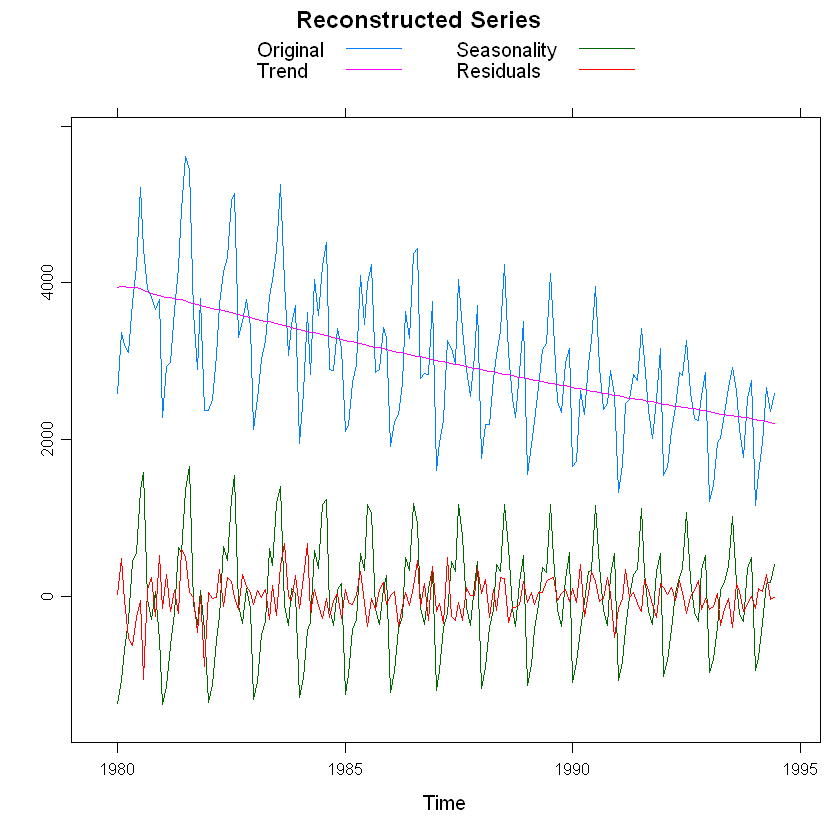

In [14]:
plot(r.fort, add.residuals=TRUE, 
     add.original=TRUE, 
     plot.method="xyplot", 
     superpose=TRUE, 
     auto.key=list(columns = 2))

Let us try to look inside the black box here. How did we come up with the grouping `groups=list(Trend = 1, Seasonality = 2:11)`? We want to separate the signal into trend, seasonality and noise. While there are automatic ways of doing this, we will do some visual analytics. Let's look first at the 50 eigenvectors:

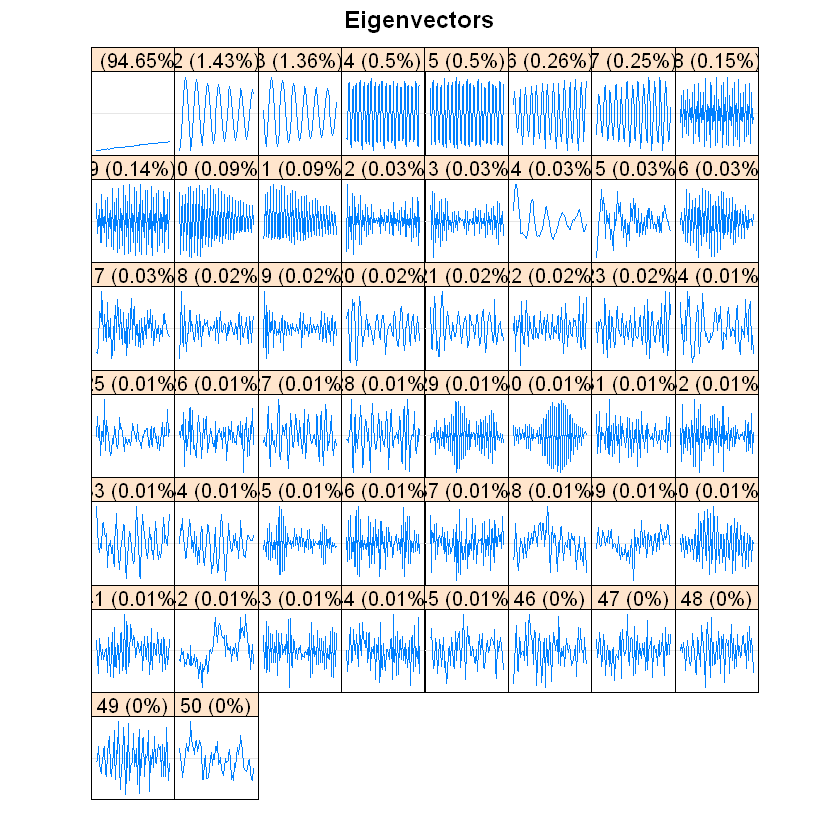

In [30]:
plot(ssa.fort, type = "vectors", idx = 1:50)

One notices immediately that eigenvector 1 is non-oscillatory. This mode is our trend:
$$
\mathbb X_{trend}=\mathbb X_1
$$
Next we look at adjacent eigenvector pair plots:

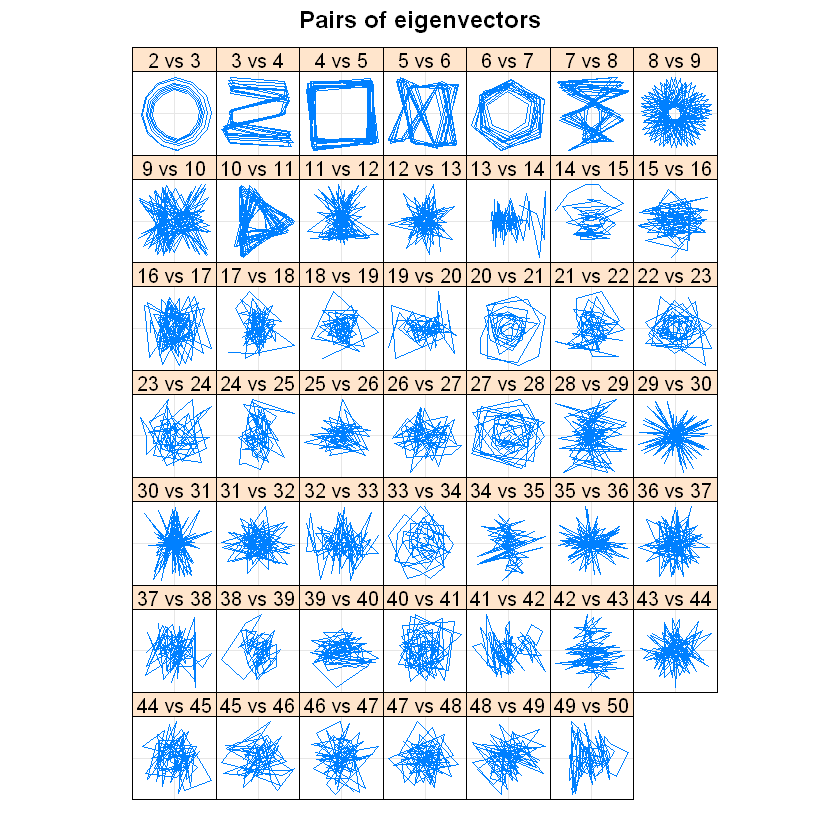

In [130]:
plot(ssa.fort, type = "paired", idx = 2:49, plot.contrib = FALSE)

The pairs 2–3, 4–5, 6–7, 8–9, 10–11 are polygons. This is the tell-tale sign of modulated periodic functions associated with seasonality. Then, 
$$
\mathbb X_{seasonality} = \sum_{i=2}^{11}\mathbb X_i
$$

The pair plots seem to indicate that the components $12$ and on are associated with noise. We can confirm this by looking at the correlation matrix:

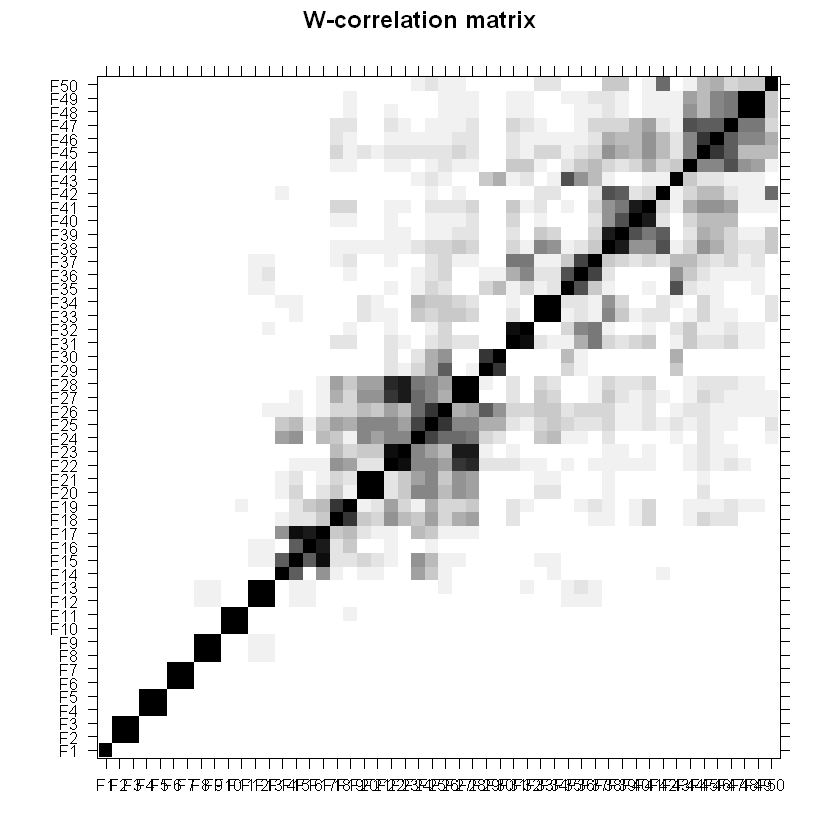

In [33]:
plot(wcor(ssa.fort, groups = 1:50))

## Dealing with complex trends using chained SSA

Let's up the complexity somewhat by also trying to figure out a grouping for tendency. First, we briefly explore the use of automated grouping, before moving onto chained SSA.


Call:
ssa(x = oilproduction, L = 120)

Series length: 300,	Window length: 120,	SVD method: eigen
Special triples:  0

Computed:
Eigenvalues: 50,	Eigenvectors: 50,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 0.05156 MiB


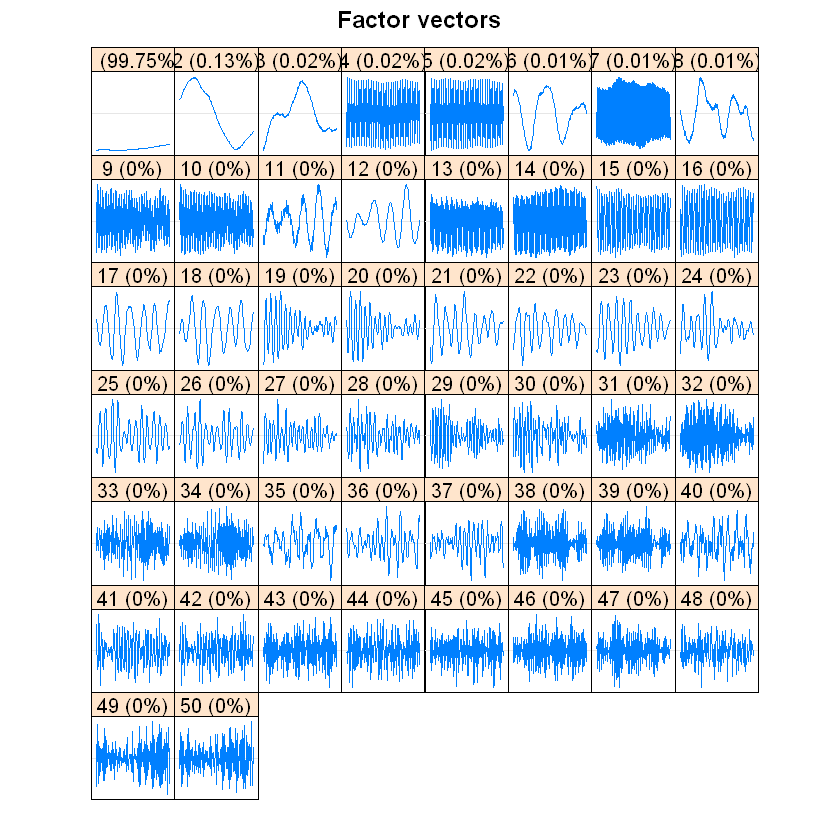

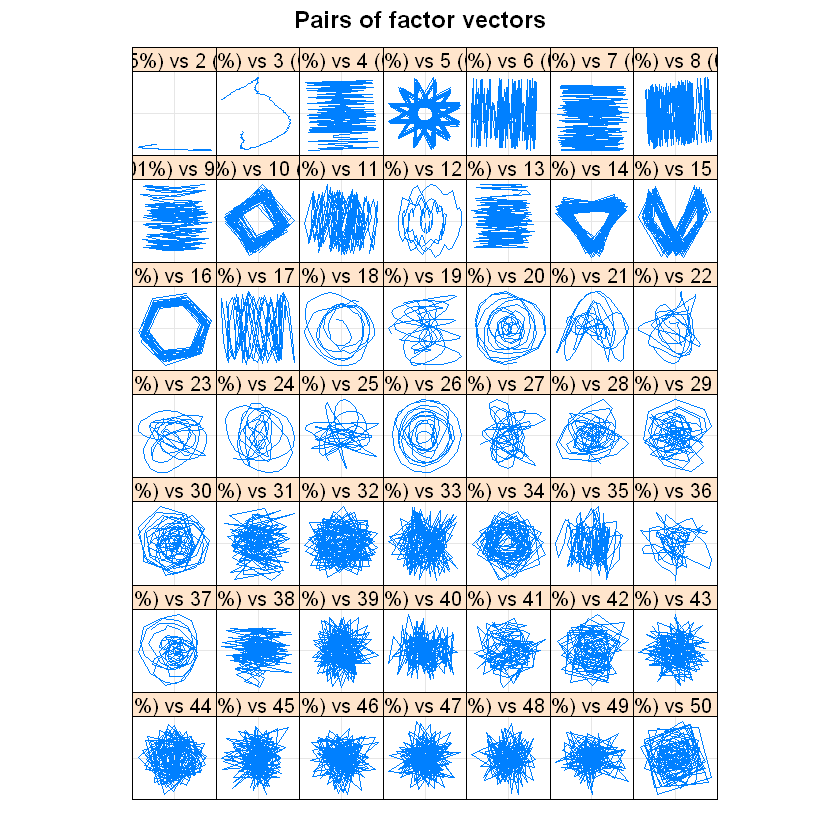

In [47]:
data("oilproduction", package = "ssabook")
s <- ssa(oilproduction, L = 120)
print(s)
plot(s, type = "vectors", vectors = "factor", idx = 1:50)
plot(s, type = "paired", vectors = "factor", idx = 1:49)

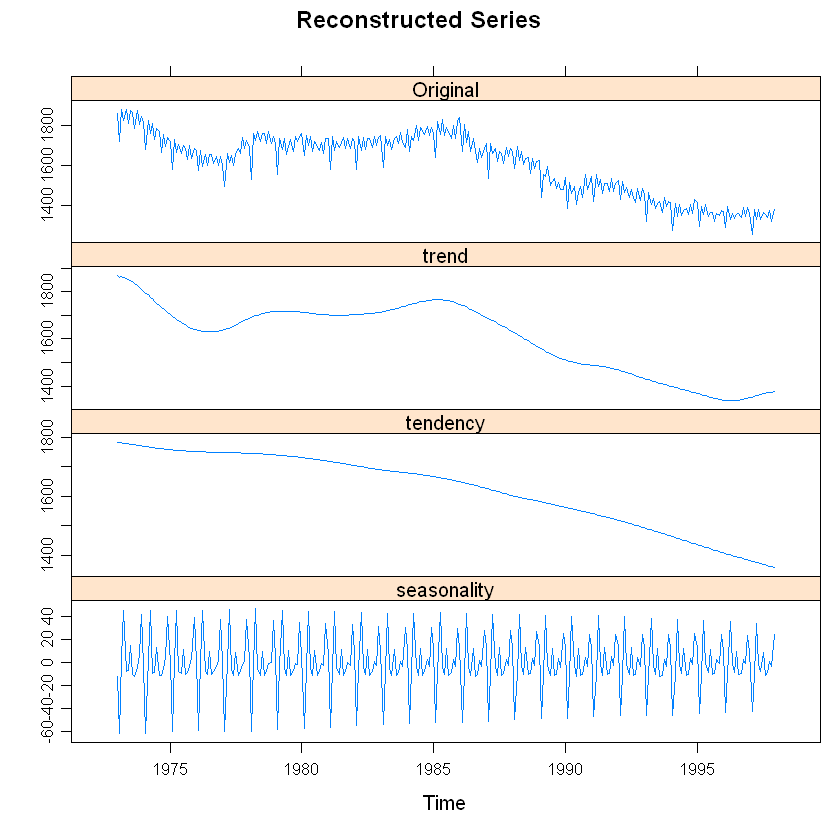

In [59]:
g <- list(trend=c(1,2,3,6,8), tendency=c(1), seasonality=c( 9,10, 13, 14, 15, 16))
r <- reconstruct(s, groups=g)
plot(r, add.residuals = FALSE, plot.method = "xyplot", superpose = FALSE)

Notice the difference between trend and tendency - the latter is a coarse-graining of the former. The automatic grouping method works well to separate these two factors given some frequency threshold:

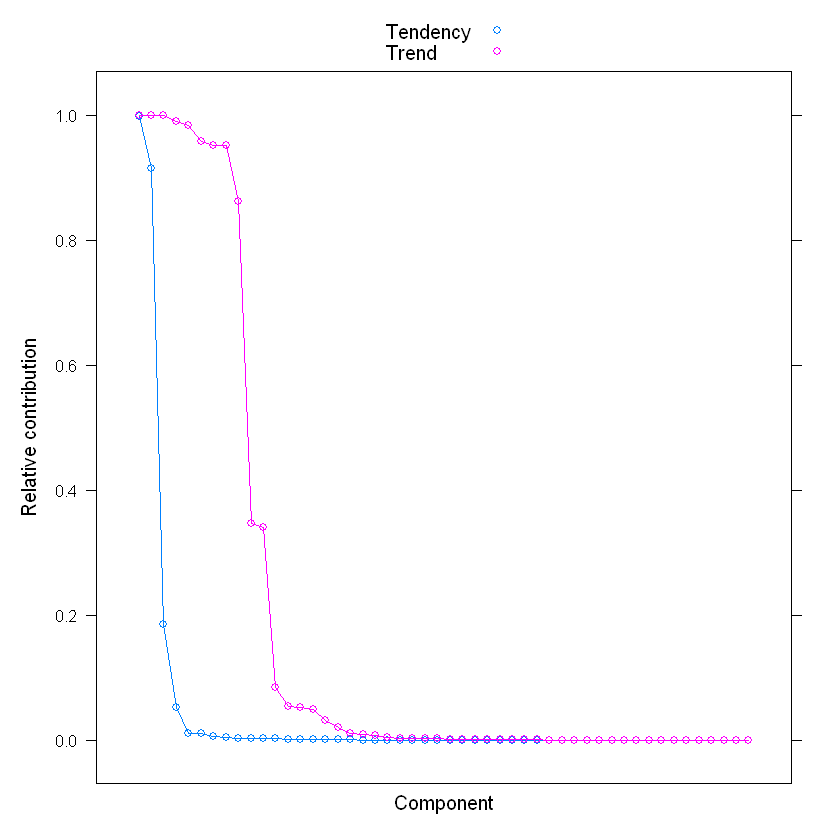

In [68]:
g.auto <- grouping.auto(s, base="series", 
                        freq.bins=list(Tendency = 1/240,Trend = 1/24),threshold = 0.1)
plot(g.auto, order = TRUE, type = "b")

When the timeseries's trend is complicated, one has to reconstruct it from a large rank $\mathbb X_{trend}$ as we saw in the previous example. This risks the separability of the decomposition and makes it likely that we also picked up seasonal behavior in the trend mode. The previous dataset actually has a fairly well-separated seasonal component. Let's take a look at another dataset with more mixing. 

One way of dealing with this mixing of factors is to chain SSA algorithms with varying window length. This is sometimes called sequential SSA. 

The first step is to extract a trend mode. Because the data is complicated, this is essentially a moving average:

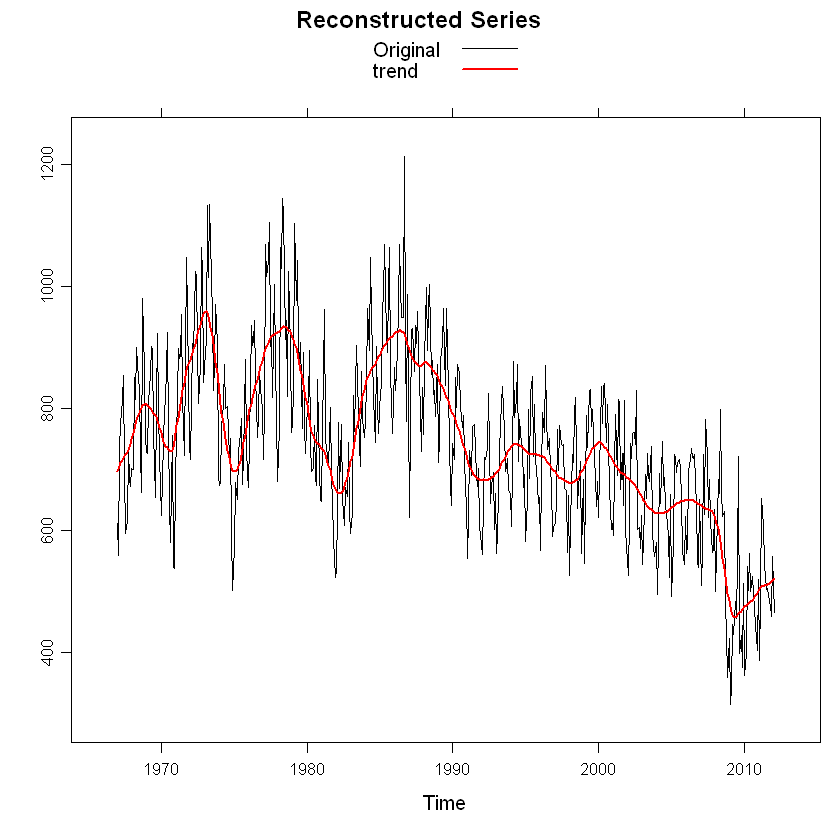

In [69]:
data("MotorVehicle", package = "Rssa")
s1 <- ssa(MotorVehicle, L = 12)
res1 <- reconstruct(s1, groups = list(trend = 1))
trend <- res1$trend
plot(res1, add.residuals = FALSE, plot.type = "single",col = c("black", "red"), lwd = c(1, 2),plot.method = "xyplot", superpose = TRUE)

We now expand the window $12\to 264$ and focus on the seasonality captured by the first 10 modes of the residual of the first step:

In [94]:
res.trend <- residuals(res1)
s2 <- ssa(res.trend, L = 264)

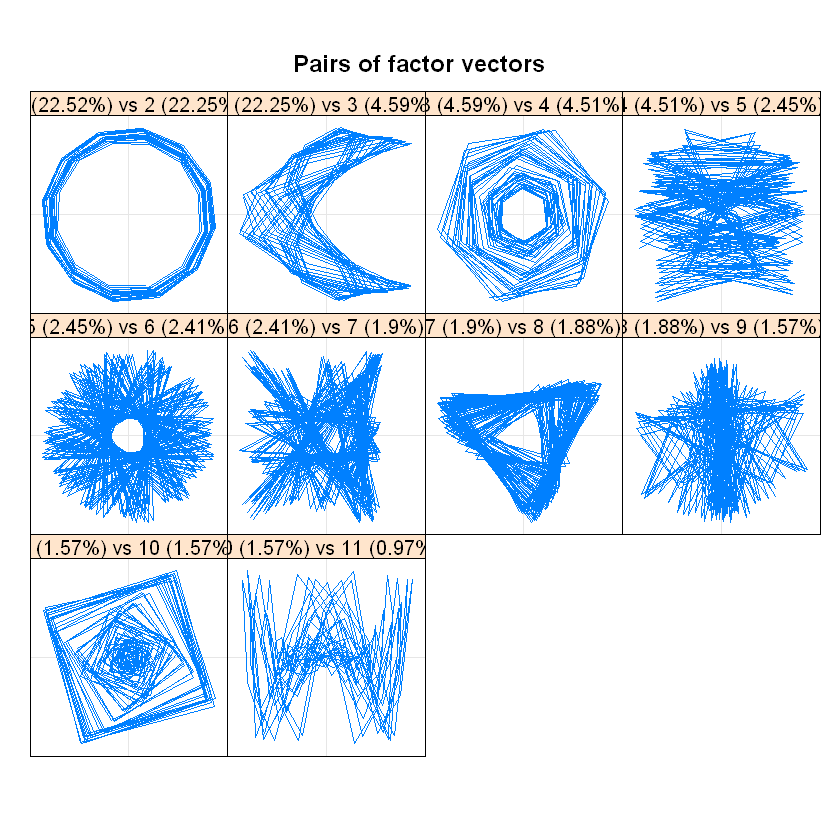

In [95]:
plot(s2, type = "paired", vectors = "factor", idx = 1:10)

In [120]:
res2 <- reconstruct(s2, groups = list(seasonality = 1:10))
seasonality <- res2$seasonality
res <- residuals(res2)

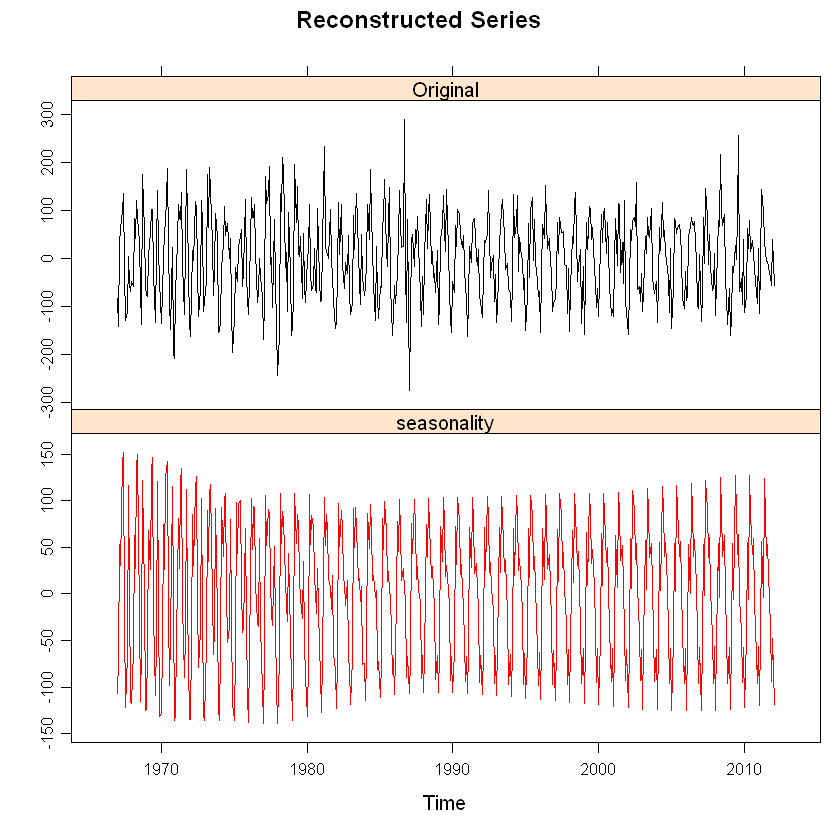

In [121]:
plot(res2, add.residuals = FALSE, plot.type = "single",col = c("black", "red"), lwd = c(1, 1),plot.method = "xyplot", superpose = FALSE)

### Heterogeneous noise

The motor vehicle example also demonstrates time varying volatility. We could model the noise envelope of the de-trended signal.

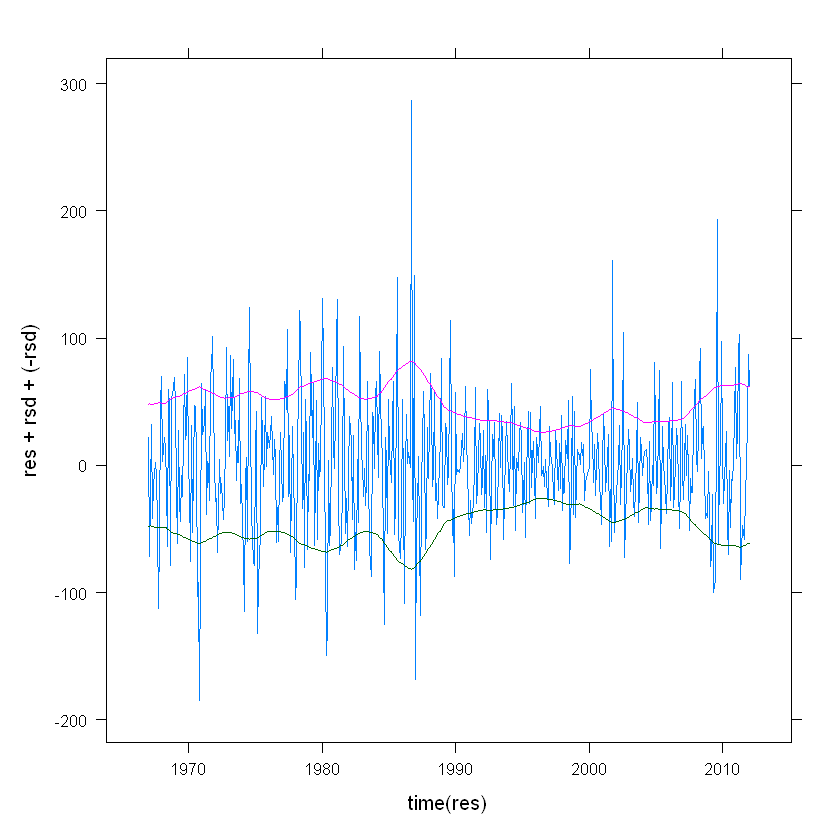

In [129]:
s.env <- ssa(res**2, L = 30)
rsd <- sqrt(reconstruct(s.env, groups = list(1))$F1)
xyplot(res + rsd + (-rsd) ~ time(res), type = "l")